## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize ##scipy optimize
import csv
import time  
#import or_gym
#from or_gym.utils import create_env
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
from datetime import datetime
sns.set_style("darkgrid")
sns.set_palette("rainbow")
sns.set_context("talk")

In [ ]:
import SupplyChain_gym

In [ ]:
from ray.tune.registry import register_env

In [ ]:
from SupplyChain_gym.envs.InventoryEnvFile import InventoryEnv
# from SupplyChain_gym.envs.NetworkManagementFile import NetInvMgmtMasterEnv
# from SupplyChain_gym.envs.NetworkManagementFile import NetInvMgmtBacklogEnv as backlog_env
# from SupplyChain_gym.envs.NetworkManagementFile import NetInvMgmtLostSalesEnv as lost_sales_env

In [ ]:
# from SupplyChain_gym.envs.InventoryManagementFile import InvManagementMasterEnv
# from SupplyChain_gym.envs.InventoryManagementFile import InvManagementBacklogEnv as env1
# from SupplyChain_gym.envs.InventoryManagementFile import InvManagementLostSalesEnv

In [ ]:
from scipy.optimize import minimize

In [ ]:
from gym import spaces

In [ ]:
import os
import math
import random

In [ ]:
from matplotlib import gridspec
import networkx as nx

## Supply Chain Environment Divergent Default

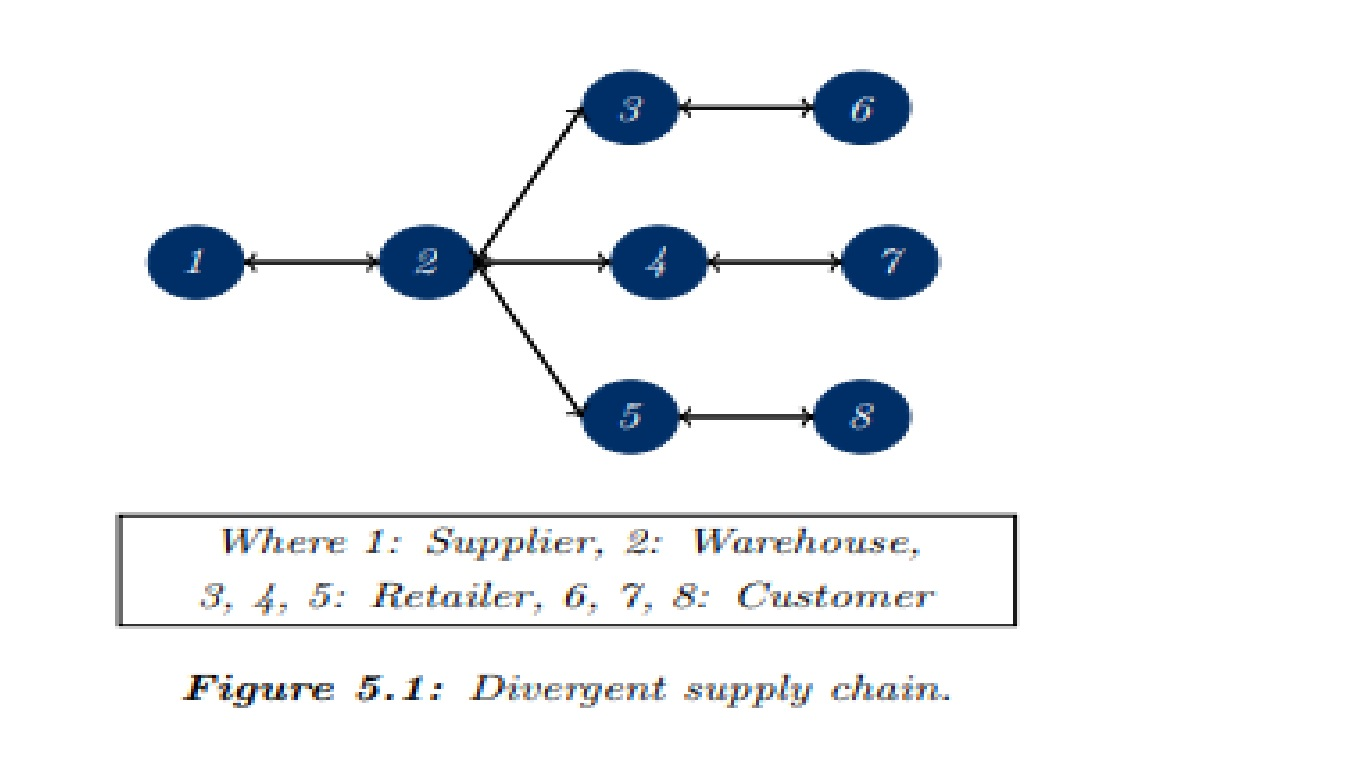

### Pseudo Algo

### Divergent Supply Chain

### General parameters

In [ ]:
stockpoints_echelon = [1, 1, 3, 3]
# Number of suppliers
no_suppliers = stockpoints_echelon[0]
# Number of customers
no_customers = stockpoints_echelon[-1]
# Number of stockpoints
no_stockpoints = sum(stockpoints_echelon) - no_suppliers - no_customers
# Total number of nodes
no_nodes = sum(stockpoints_echelon)
# Total number of echelons, including supplier and customer
no_echelons = len(stockpoints_echelon)
demand_dist = 'poisson'
# Lower bound of the demand distribution
demand_lb = 15
#Upper bound of the demand distribution
demand_ub = 15
# Leadtime distribution, can only be 'uniform'
leadtime_dist = 'uniform'

In [ ]:
# for i,j in enumerate(range(no_suppliers,no_nodes-no_customers)):
#     print(state_high[2+i:2+i+1][0])

In [ ]:
# i_list, j_list = np.nonzero(connections)
# for i, j in zip(i_list[:-no_customers], j_list[:-no_customers]):
#     print(i,j)

In [ ]:
connections = np.array([
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0]
                        ])

In [ ]:
i_list, j_list = np.nonzero(connections)
j_list

In [ ]:
cnt=0
i_list, j_list = np.nonzero(connections)
for i, j in zip(i_list[:-no_customers], j_list[:-no_customers]):
        print(i,j)
        cnt+=1
print(cnt)

In [ ]:
i_list, j_list = np.nonzero(connections)
for i, j in zip(i_list[no_suppliers:no_suppliers+no_stockpoints],
                j_list[no_suppliers:no_suppliers+no_stockpoints]):
    print(i,j)

In [ ]:
# Loop over all suppliers and stockpoints
for i in range(0, no_stockpoints + no_suppliers):
# Loop over all stockpoints
# Note that only forward delivery is possible, hence 'i+1'
    for j in range(i + 1, no_stockpoints +no_suppliers):
        print(i,j)
           #delivery = self.T[0, i, j]
           #self.INV[0, j] += delivery
           #self.in_transit[0, i, j] = 0
           #self.T[0, i, j] = 0

### Divergent class lost sales

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [ ]:
class Divergent:
    """ Based on the case of the SC Company """

    def __init__(self):
        # Supply chain variables
        # Number of nodes per echelon, including suppliers and customers
        # The first element is the number of suppliers
        # The last element is the number of customers
        self.stockpoints_echelon = [1, 1, 3, 3]
        # Number of suppliers
        self.no_suppliers = self.stockpoints_echelon[0]
        # Number of customers
        self.no_customers = self.stockpoints_echelon[-1]
        # Number of stockpoints
        self.no_stockpoints = sum(self.stockpoints_echelon) - \
        self.no_suppliers - self.no_customers
        
        # Total number of nodes
        self.no_nodes = sum(self.stockpoints_echelon)
        # Total number of echelons, including supplier and customer
        self.no_echelons = len(self.stockpoints_echelon)
        # Connections between every stockpoint
        self.connections = np.array([
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0]
                        ])
        # Determines what happens with unsatisfied demand, can be either 'backorders' or 'lost_sales'
        self.unsatisfied_demand = 'backorders'
        self.initial_inventory = [1000000, 0, 0, 0, 0, 0, 0, 0]
        # Holding costs per stockpoint # for both warehouse and plants
        self.holding_costs = [0, 0.6, 1, 1, 1, 0, 0, 0]
        # Backorder costs per stockpoint #only for WHs here
        self.bo_costs =[0, 0.6, 1, 1, 1, 0, 0, 0]
        # Demand distribution, can be either 'poisson' or 'uniform'
        self.demand_dist = 'poisson'
        # Lower bound of the demand distribution
        self.demand_lb = 100
        # Upper bound of the demand distribution
        self.demand_ub = 150
        # Leadtime distribution, can only be 'uniform'
        self.leadtime_dist = 'uniform'
        # Lower bound of the leadtime distribution
        
        self.leadtime_lb = 1
        # Upper bound of the leadtime distribution
        self.leadtime_ub = 1
        # Predetermined order policy, can be either 'X' or 'X+Y' or 'BaseStock'
        self.order_policy = 'X'
        self.horizon = 75
        self.warmup = 50
        self.divide = 1000
        self.action_low = np.array([-1,-1,-1,-1]) #9
        self.action_high = np.array([1,1,1,1])    #9
        self.action_min = np.array([0,0,0,0])  #9 #first 4 from plants last 5 from WHs orderQty
        self.action_max = np.array([300,75,75,75]) #9 #first 4 from plants last 5 from WHs orderQty
        self.state_low = np.zeros(13)
        self.state_high = np.array([1000, 450,  # Total inventory and backorders
        250,250,250,250,# Inventory per stockpoint
        #11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, #per connection backorder
        150,150,150, # Backorders per stockpoint
        #30, 31, 32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
        150,150,150,150]) # In transit per stockpoint

In [ ]:
case_name='Divergent'
stockpoints_echelon = [1, 1, 3, 3]
# Number of suppliers
no_suppliers = stockpoints_echelon[0]
# Number of customers
no_customers = stockpoints_echelon[-1]
# Number of stockpoints
no_stockpoints = sum(stockpoints_echelon) - \
no_suppliers - no_customers

# Total number of nodes
no_nodes = sum(stockpoints_echelon)
# Total number of echelons, including supplier and customer
no_echelons = len(stockpoints_echelon)
# Connections between every stockpoint
connections = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0]
                        ])
# Determines what happens with unsatisfied demand, can be either 'backorders' or 'lost_sales'
#unsatisfied_demand = 'backorders'
unsatisfied_demand = 'lostsales' #'backorders'
initial_inventory = [1000000, 0, 0, 0, 0, 0, 0, 0]
# Holding costs per stockpoint # for both warehouse and plants
holding_costs = [0,7, 10, 10, 10, 0, 0, 0]
# Backorder costs per stockpoint #only for WHs here
bo_costs = [0, 13, 16, 16, 16, 0, 0, 0]
lo_costs = [0, 16, 19, 19, 19, 0, 0, 0]
# Demand distribution, can be either 'poisson' or 'uniform'
demand_dist = 'poisson'
# Lower bound of the demand distribution
demand_lb = 10
# Upper bound of the demand distribution
demand_ub = 50
# Leadtime distribution, can only be 'uniform'
leadtime_dist = 'uniform'
# Lower bound of the leadtime distribution
leadtime_lb = 1
# Upper bound of the leadtime distribution
leadtime_ub = 1
##periods
num_of_periods=5
##price
cost_price=[5, 0, 0, 0, 0, 0, 0, 0]
selling_price=[0, 0, 20, 20, 20, 0, 0, 0]
# Predetermined order policy, can be either 'X' or 'X+Y' or 'BaseStock'
order_policy = 'X'
leadtime=1
horizon = 75
n=10
coded=True
warmup = 25
divide = 1000
action_low = np.array([-1,-1,-1,-1]) #9
action_high = np.array([1,1,1,1])    #9
action_min = np.array([0,0,0,0])  #9 #first 4 from plants last 5 from WHs orderQty
action_max = np.array([100,75,75,75]) #9 #first 4 from plants last 5 from WHs orderQty
state_low = np.zeros(16)
state_high = np.array([2000, 1500,  # Total inventory and backorders
        500,500,500,500,# Inventory per stockpoint
        #11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, #per connection backorder
        250,250,250,250,250,250, # Backorders per stockpoint ##shall change this to 6 per i,j connection
        #30, 31, 32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
        250,250,250,250]) # In transit per stockpoint

In [ ]:
# i_list, j_list = np.nonzero(case.connections)
# for i, j in zip(i_list[-case.no_customers:], j_list[-case.no_customers:]):
#     print(i,j)

In [ ]:
# # PPO Settings
# # activation function of network
# network_activation = 'tanh'
# # size of network
# network_size = (64, 64)
# # initial values of bias in network
# network_bias_init = 0.0
# # method of weight initialization for network (uniform or normal)
# network_weights_init = 'uniform'
# # number of iterations between evaluation
# ppo_evaluation_steps = 500
# #number of consecutive evaluation iterations without improvement
# ppo_evaluation_threshold = 250
# # maximum number of iterations in learning run
# ppo_iterations = 50000
# # length of one episode in buffer
# ppo_buffer_length = 256
# # discount factor used in GAE calculations
# ppo_gamma = 0.99
# # lambda rate used in GAE calculations
# ppo_lambda = 0.95
# # indicator of using a cooldown period in the buffer (boolean)
# cooldown_buffer = False
# # clipping value used in policy loss calculations
# ppo_epsilon = 0.2
# # learning rate for policy network
# pi_lr = 1e-4
# # learning rate for value network
# vf_lr = 1e-4
# # after x iterations, save model weights and histograms to tensorboard
# ppo_save_freq = 500
# # nr of epochs (i.e. repetitions of the buffer) used in updating the model weights
# ppo_epochs = 10
# # batch size used to split the buffer for updating the model weights
# ppo_batch_size = 64
# # number of simulation runs to compute benchmark and as stopping criterion
# ppo_simulation_runs = 100
# # length of simulation to compute benchmark and as stopping criterion
# ppo_simulation_length = 75#horizon
# # length of initial simulation that is discarded
# ppo_warmup_period = 50#warmup
# policy_results_states = [[0,12,12,12,12]] #dont know about this

In [ ]:
# for k in range(1):
#     print("Replication " + str(k))
#     # Initialize environment
#     env = InventoryEnv(case, case.action_low, case.action_high,
#                        case.action_min, case.action_max, case.state_low, case.state_high,
#                        'DRL', fix=True)
#     run_name = "RN{}".format(k)
#     # set random seed
#     #set_seeds(env, k)
#     # call learning function
#     ppo_learning(env, False, experiment_name, run_name,
#                  network_activation, network_size, network_bias_init, network_weights_init,
#                  ppo_evaluation_steps, ppo_evaluation_threshold,
#                  ppo_iterations, ppo_buffer_length, ppo_gamma, ppo_lambda, cooldown_buffer,
#                  ppo_epsilon, pi_lr, vf_lr, ppo_save_freq, ppo_epochs, ppo_batch_size,
#                  ppo_simulation_runs, ppo_simulation_length, ppo_warmup_period, policy_results_states)

In [ ]:
# case=Divergent()

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\\supplychainv0\divergent\lostsales"

In [ ]:
import shutil
import os 
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [ ]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "WARN"

In [ ]:
select_env = "SupplyChainEnv-v0" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0

In [ ]:
# register_env(select_env, lambda x: InventoryEnv(case, case.action_low, case.action_high,
#                        case.action_min, case.action_max, case.state_low, case.state_high,
#                        'DRL', fix=True))

In [ ]:
env_config = {'case_name' : case_name,
              'stockpoints_echelon' : stockpoints_echelon,
              'no_suppliers' : no_suppliers,
              'no_customers' : no_customers,
              'no_stockpoints' : no_stockpoints,
              'no_suppliers' : no_suppliers,
              'no_nodes' : no_nodes,
              'no_echelons' : no_echelons,
              'connections' : connections,
              'unsatisfied_demand' : unsatisfied_demand,
              'holding_costs' : holding_costs,
              'bo_costs' : bo_costs,
              'lo_costs': lo_costs,
              'demand_dist' : demand_dist,
              'demand_lb' : demand_lb,
              'demand_ub' : demand_ub,
              'leadtime_dist' : leadtime_dist,
              'leadtime_lb' : leadtime_lb,
              'leadtime_ub' : leadtime_ub,
              'num_of_periods' : num_of_periods,
              'cost_price' : cost_price,
              'selling_price' : selling_price,
              'order_policy' : order_policy,
              'horizon' : horizon,
              'warmup' : warmup,
              'divide' : divide,
              'coded' : False,
              'fix' : True,
              'ipfix' : True,
              'method' : 'DRL',
              'leadtime':leadtime,
              'n':n,
              'action_low' : action_low,
              'action_high' : action_high,
              'action_min' : action_min,
              'action_max' : action_max,
              'state_low' : state_low,
              'state_high' : state_high
             }
#env_config

In [ ]:
#register_env(select_env, lambda config :InventoryEnv(env_config=env_config))
register_env(select_env, lambda config :InventoryEnv(env_config=env_config))

In [ ]:
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
N_ITER=1
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])

In [ ]:
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Divergent class lost sales Predict using checkpoint

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [ ]:
import gym

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\supplychainv0\divergent\\lostsales"

In [ ]:
newest(CHECKPOINT_ROOT)

In [ ]:
#chkpt_file=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\divergent\checkpoint_000001'
chkpt_file=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\supplychainv0\divergent\\lostsales\checkpoint_000001\checkpoint-1'
agent.restore(chkpt_file)

In [ ]:
case_name='Divergent'
stockpoints_echelon = [1, 1, 3, 3]
# Number of suppliers
no_suppliers = stockpoints_echelon[0]
# Number of customers
no_customers = stockpoints_echelon[-1]
# Number of stockpoints
no_stockpoints = sum(stockpoints_echelon) - \
no_suppliers - no_customers

# Total number of nodes
no_nodes = sum(stockpoints_echelon)
# Total number of echelons, including supplier and customer
no_echelons = len(stockpoints_echelon)
# Connections between every stockpoint
connections = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0]
                        ])
# Determines what happens with unsatisfied demand, can be either 'backorders' or 'lost_sales'
unsatisfied_demand = 'lostsales' #or 'backorders'
initial_inventory = [1000000, 0, 0, 0, 0, 0, 0, 0]
# Holding costs per stockpoint # for both warehouse and plants
holding_costs = [0,7, 10, 10, 10, 0, 0, 0]
# Backorder costs per stockpoint #only for WHs here
bo_costs = [0, 13, 16, 16, 16, 0, 0, 0]
lo_costs = [0, 16, 19, 19, 19, 0, 0, 0]
# Demand distribution, can be either 'poisson' or 'uniform'
demand_dist = 'poisson'
# Lower bound of the demand distribution
demand_lb = 10
# Upper bound of the demand distribution
demand_ub = 50
# Leadtime distribution, can only be 'uniform'
leadtime_dist = 'uniform'
# Lower bound of the leadtime distribution
leadtime_lb = 1
# Upper bound of the leadtime distribution
leadtime_ub = 1
##periods
num_of_periods=5
##price
cost_price=[5, 0, 0, 0, 0, 0, 0, 0]
selling_price=[0, 0, 20, 20, 20, 0, 0, 0]
# Predetermined order policy, can be either 'X' or 'X+Y' or 'BaseStock'
order_policy = 'X'
leadtime=1
horizon = 75
n=10
coded=True
warmup = 25
divide = 1000
action_low = np.array([-1,-1,-1,-1]) #9
action_high = np.array([1,1,1,1])    #9
action_min = np.array([0,0,0,0])  #9 #first 4 from plants last 5 from WHs orderQty
action_max = np.array([100,75,75,75]) #9 #first 4 from plants last 5 from WHs orderQty
state_low = np.zeros(16)
state_high = np.array([2000, 1500,  # Total inventory and backorders
        500,500,500,500,# Inventory per stockpoint
        #11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, #per connection backorder
        250,250,250,250,250,250, # Backorders per stockpoint ##shall change this to 6 per i,j connection
        #30, 31, 32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
        250,250,250,250]) # In transit per stockpoint

In [ ]:
env_config = {'case_name' : case_name,
              'stockpoints_echelon' : stockpoints_echelon,
              'no_suppliers' : no_suppliers,
              'no_customers' : no_customers,
              'no_stockpoints' : no_stockpoints,
              'no_suppliers' : no_suppliers,
              'no_nodes' : no_nodes,
              'no_echelons' : no_echelons,
              'connections' : connections,
              'unsatisfied_demand' : unsatisfied_demand,
              'holding_costs' : holding_costs,
              'bo_costs' : bo_costs,
              'lo_costs': lo_costs,
              'demand_dist' : demand_dist,
              'demand_lb' : demand_lb,
              'demand_ub' : demand_ub,
              'leadtime_dist' : leadtime_dist,
              'leadtime_lb' : leadtime_lb,
              'leadtime_ub' : leadtime_ub,
              'num_of_periods' : num_of_periods,
              'cost_price' : cost_price,
              'selling_price' : selling_price,
              'order_policy' : order_policy,
              'horizon' : horizon,
              'warmup' : warmup,
              'divide' : divide,
              'coded' : False,
              'fix' : True,
              'ipfix' : True,
              'method' : 'DRL',
              'leadtime':leadtime,
              'n':n,
              'action_low' : action_low,
              'action_high' : action_high,
              'action_min' : action_min,
              'action_max' : action_max,
              'state_low' : state_low,
              'state_high' : state_high
             }
#env_config

In [ ]:
#register_env(select_env,lambda config :backlog_env(case))
env = gym.make(select_env,env_config=env_config)
state = env.reset()

In [ ]:
state

In [ ]:
sum_reward = 0
n_step = 20
reward_list=[]
for step in range(n_step):
    print('Step',step)
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)
    reward_list.append(reward)
    sum_reward += reward
    print('Step Reward',reward)
    print('Sum Reward',sum_reward)
    print('Next State',state)
    #env.render()
    if done == 1:
        print(f'Final Cumulative Reward:{sum_reward:.1f}')
        state = env.reset()
        sum_reward = 0

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(reward_list)
plt.title('Step Wise Reward')
plt.show()

### Divergent class Backorder

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [ ]:
case_name='Divergent'
stockpoints_echelon = [1, 1, 3, 3]
# Number of suppliers
no_suppliers = stockpoints_echelon[0]
# Number of customers
no_customers = stockpoints_echelon[-1]
# Number of stockpoints
no_stockpoints = sum(stockpoints_echelon) - \
no_suppliers - no_customers

# Total number of nodes
no_nodes = sum(stockpoints_echelon)
# Total number of echelons, including supplier and customer
no_echelons = len(stockpoints_echelon)
# Connections between every stockpoint
connections = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0]
                        ])
# Determines what happens with unsatisfied demand, can be either 'backorders' or 'lost_sales'
#unsatisfied_demand = 'backorders'
unsatisfied_demand = 'backorders' #'lostsales' #'backorders'
initial_inventory = [1000000, 0, 0, 0, 0, 0, 0, 0]
# Holding costs per stockpoint # for both warehouse and plants
holding_costs = [0,7, 10, 10, 10, 0, 0, 0]
# Backorder costs per stockpoint #only for WHs here
bo_costs = [0, 13, 16, 16, 16, 0, 0, 0]
lo_costs = [0, 16, 19, 19, 19, 0, 0, 0]
# Demand distribution, can be either 'poisson' or 'uniform'
demand_dist = 'poisson'
# Lower bound of the demand distribution
demand_lb = 10
# Upper bound of the demand distribution
demand_ub = 50
# Leadtime distribution, can only be 'uniform'
leadtime_dist = 'uniform'
# Lower bound of the leadtime distribution
leadtime_lb = 1
# Upper bound of the leadtime distribution
leadtime_ub = 1
##periods
num_of_periods=5
##price
cost_price=[5, 0, 0, 0, 0, 0, 0, 0]
selling_price=[0, 0, 20, 20, 20, 0, 0, 0]
# Predetermined order policy, can be either 'X' or 'X+Y' or 'BaseStock'
order_policy = 'X'
leadtime=1
horizon = 75
n=10
coded=True
warmup = 25
divide = 1000
action_low = np.array([-1,-1,-1,-1]) #9
action_high = np.array([1,1,1,1])    #9
action_min = np.array([0,0,0,0])  #9 #first 4 from plants last 5 from WHs orderQty
action_max = np.array([100,75,75,75]) #9 #first 4 from plants last 5 from WHs orderQty
state_low = np.zeros(16)
state_high = np.array([2000, 1500,  # Total inventory and backorders
        500,500,500,500,# Inventory per stockpoint
        #11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, #per connection backorder
        250,250,250,250,250,250, # Backorders per stockpoint ##shall change this to 6 per i,j connection
        #30, 31, 32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
        250,250,250,250]) # In transit per stockpoint

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\\supplychainv0\divergent\backorder"

In [ ]:
import shutil
import os 
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [ ]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "WARN"

In [ ]:
select_env = "SupplyChainEnv-v0" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0

In [ ]:
env_config = {'case_name' : case_name,
              'stockpoints_echelon' : stockpoints_echelon,
              'no_suppliers' : no_suppliers,
              'no_customers' : no_customers,
              'no_stockpoints' : no_stockpoints,
              'no_suppliers' : no_suppliers,
              'no_nodes' : no_nodes,
              'no_echelons' : no_echelons,
              'connections' : connections,
              'unsatisfied_demand' : unsatisfied_demand,
              'holding_costs' : holding_costs,
              'bo_costs' : bo_costs,
              'lo_costs': lo_costs,
              'demand_dist' : demand_dist,
              'demand_lb' : demand_lb,
              'demand_ub' : demand_ub,
              'leadtime_dist' : leadtime_dist,
              'leadtime_lb' : leadtime_lb,
              'leadtime_ub' : leadtime_ub,
              'num_of_periods' : num_of_periods,
              'cost_price' : cost_price,
              'selling_price' : selling_price,
              'order_policy' : order_policy,
              'horizon' : horizon,
              'warmup' : warmup,
              'divide' : divide,
              'coded' : False,
              'fix' : True,
              'ipfix' : True,
              'method' : 'DRL',
              'leadtime':leadtime,
              'n':n,
              'action_low' : action_low,
              'action_high' : action_high,
              'action_min' : action_min,
              'action_max' : action_max,
              'state_low' : state_low,
              'state_high' : state_high
             }
#env_config

In [ ]:
#register_env(select_env, lambda config :InventoryEnv(env_config=env_config))
register_env(select_env, lambda config :InventoryEnv(env_config=env_config))

In [ ]:
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
N_ITER=1
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Divergent class Backorder predict using checkpoint

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [ ]:
import gym
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\supplychainv0\divergent\backorder"
newest(CHECKPOINT_ROOT)
#chkpt_file=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\divergent\checkpoint_000001'

In [ ]:
chkpt_file=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\supplychainv0\divergent\backorder\checkpoint_000001\checkpoint-1'
agent.restore(chkpt_file)

In [ ]:
case_name='Divergent'
stockpoints_echelon = [1, 1, 3, 3]
# Number of suppliers
no_suppliers = stockpoints_echelon[0]
# Number of customers
no_customers = stockpoints_echelon[-1]
# Number of stockpoints
no_stockpoints = sum(stockpoints_echelon) - \
no_suppliers - no_customers

# Total number of nodes
no_nodes = sum(stockpoints_echelon)
# Total number of echelons, including supplier and customer
no_echelons = len(stockpoints_echelon)
# Connections between every stockpoint
connections = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0]
                        ])
# Determines what happens with unsatisfied demand, can be either 'backorders' or 'lost_sales'
unsatisfied_demand = 'backorders' #or 'backorders'
initial_inventory = [1000000, 0, 0, 0, 0, 0, 0, 0]
# Holding costs per stockpoint # for both warehouse and plants
holding_costs = [0,7, 10, 10, 10, 0, 0, 0]
# Backorder costs per stockpoint #only for WHs here
bo_costs = [0, 13, 16, 16, 16, 0, 0, 0]
lo_costs = [0, 16, 19, 19, 19, 0, 0, 0]
# Demand distribution, can be either 'poisson' or 'uniform'
demand_dist = 'poisson'
# Lower bound of the demand distribution
demand_lb = 10
# Upper bound of the demand distribution
demand_ub = 50
# Leadtime distribution, can only be 'uniform'
leadtime_dist = 'uniform'
# Lower bound of the leadtime distribution
leadtime_lb = 1
# Upper bound of the leadtime distribution
leadtime_ub = 1
##periods
num_of_periods=5
##price
cost_price=[5, 0, 0, 0, 0, 0, 0, 0]
selling_price=[0, 0, 20, 20, 20, 0, 0, 0]
# Predetermined order policy, can be either 'X' or 'X+Y' or 'BaseStock'
order_policy = 'X'
leadtime=1
horizon = 75
n=10
coded=True
warmup = 25
divide = 1000
action_low = np.array([-1,-1,-1,-1]) #9
action_high = np.array([1,1,1,1])    #9
action_min = np.array([0,0,0,0])  #9 #first 4 from plants last 5 from WHs orderQty
action_max = np.array([100,75,75,75]) #9 #first 4 from plants last 5 from WHs orderQty
state_low = np.zeros(16)
state_high = np.array([2000, 1500,  # Total inventory and backorders
        500,500,500,500,# Inventory per stockpoint
        #11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, #per connection backorder
        250,250,250,250,250,250, # Backorders per stockpoint ##shall change this to 6 per i,j connection
        #30, 31, 32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
        250,250,250,250]) # In transit per stockpoint

In [ ]:
env_config = {'case_name' : case_name,
              'stockpoints_echelon' : stockpoints_echelon,
              'no_suppliers' : no_suppliers,
              'no_customers' : no_customers,
              'no_stockpoints' : no_stockpoints,
              'no_suppliers' : no_suppliers,
              'no_nodes' : no_nodes,
              'no_echelons' : no_echelons,
              'connections' : connections,
              'unsatisfied_demand' : unsatisfied_demand,
              'holding_costs' : holding_costs,
              'bo_costs' : bo_costs,
              'lo_costs': lo_costs,
              'demand_dist' : demand_dist,
              'demand_lb' : demand_lb,
              'demand_ub' : demand_ub,
              'leadtime_dist' : leadtime_dist,
              'leadtime_lb' : leadtime_lb,
              'leadtime_ub' : leadtime_ub,
              'num_of_periods' : num_of_periods,
              'cost_price' : cost_price,
              'selling_price' : selling_price,
              'order_policy' : order_policy,
              'horizon' : horizon,
              'warmup' : warmup,
              'divide' : divide,
              'coded' : False,
              'fix' : True,
              'ipfix' : True,
              'method' : 'DRL',
              'leadtime':leadtime,
              'n':n,
              'action_low' : action_low,
              'action_high' : action_high,
              'action_min' : action_min,
              'action_max' : action_max,
              'state_low' : state_low,
              'state_high' : state_high
             }
#env_config

In [ ]:
#register_env(select_env,lambda config :backlog_env(case))
env = gym.make(select_env,env_config=env_config)
state = env.reset()

In [ ]:
sum_reward = 0
n_step = 20
reward_list=[]
for step in range(n_step):
    print('Step',step)
    action = agent.compute_action(state)
    state, reward, done, info = env.step(action)
    reward_list.append(reward)
    sum_reward += reward
    print('Step Reward',reward)
    print('Sum Reward',sum_reward)
    print('Next State',state)
    #env.render()
    if done == 1:
        print(f'Final Cumulative Reward:{sum_reward:.1f}')
        state = env.reset()
        sum_reward = 0

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(reward_list)
plt.title('Step Wise Reward')
plt.show()

## Change Network and Parameters

In [ ]:
# observation space (total inventory at each node, which is any integer value)
# State is a concatenation of demand, inventory, and pipeline at each time step
#demand of retailer-customer 1 nodes
#inventory of main nodes  6 nodes
#pipeline at each time step ..since thh total pipeline is 61 days leadtime #61+6+1=68
#np.iinfo Machine limits for integer types.

In [ ]:
# Make for 2 Retailers 2,3 and their customers are 0,1 respectively 

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [ ]:
case_name='Divergent'
stockpoints_echelon = [1,1,3,3, 3]
# Number of suppliers
no_suppliers = stockpoints_echelon[0]
# Number of customers
no_customers = stockpoints_echelon[-1]
# Number of stockpoints
no_stockpoints = sum(stockpoints_echelon) - \
no_suppliers - no_customers

# Total number of nodes
no_nodes = sum(stockpoints_echelon)
# Total number of echelons, including supplier and customer
no_echelons = len(stockpoints_echelon)
# Connections between every stockpoint
connections = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                        ])
# Determines what happens with unsatisfied demand, can be either 'backorders' or 'lost_sales'
#unsatisfied_demand = 'backorders'
unsatisfied_demand = 'backorders' #'lostsales' #'backorders'
initial_inventory = [1000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# Holding costs per stockpoint # for both warehouse and plants
holding_costs = [0,7, 10, 10, 10,12, 12, 12, 0, 0, 0]
# Backorder costs per stockpoint #only for WHs here
bo_costs = [0, 13, 16, 16, 16, 16, 16, 16, 0, 0, 0]
lo_costs = [0, 16, 19, 19, 19, 19, 19, 19, 0, 0, 0]
# Demand distribution, can be either 'poisson' or 'uniform'
demand_dist = 'poisson'
# Lower bound of the demand distribution
demand_lb = 10
# Upper bound of the demand distribution
demand_ub = 50
# Leadtime distribution, can only be 'uniform'
leadtime_dist = 'uniform'
# Lower bound of the leadtime distribution
leadtime_lb = 1
# Upper bound of the leadtime distribution
leadtime_ub = 1
##periods
num_of_periods=5
##price
cost_price=[5, 0, 0, 0, 0,0, 0, 0, 0, 0, 0]
selling_price=[0, 0,0, 0, 0, 20, 20, 20, 0, 0, 0]
# Predetermined order policy, can be either 'X' or 'X+Y' or 'BaseStock'
order_policy = 'X'
leadtime=1
horizon = 75
n=10
coded=True
warmup = 25
divide = 1000
action_low = np.array([-1,-1,-1,-1,-1,-1,-1]) #9
action_high = np.array([1,1,1,1,1,1,1])    #9
action_min = np.array([0,0,0,0,0,0,0])  #9 #first 4 from plants last 5 from WHs orderQty
action_max = np.array([100,75,75,75,75,75,75]) #9 #first 4 from plants last 5 from WHs orderQty
state_low = np.zeros(25)
state_high = np.array([4000, 2500,  # Total inventory and backorders
        500,500,500,500,500,500,500,# Inventory per stockpoint
        #11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, #per connection backorder
        250,250,250,250,250,250,250,250,250, # Backorders per stockpoint ##shall change this to 6 per i,j connection
        #30, 31, 32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
        250,250,250,250,250,250,250]) # In transit per stockpoint

In [ ]:
ray.shutdown()
ray.init(ignore_reinit_error=True,local_mode=True)

In [ ]:
CHECKPOINT_ROOT = r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\multi-echelon-RL\model\\supplychainv0\divergent\userdefined"

In [ ]:
import shutil
import os 
if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

In [ ]:
config = ppo.DEFAULT_CONFIG.copy()
config
config["log_level"] = "WARN"

In [ ]:
select_env = "SupplyChainEnv-v0" #NetworkManagement-v1 #NetworkManagement-v2 #SupplyChainEnv-v0

In [ ]:
env_config = {'case_name' : case_name,
              'stockpoints_echelon' : stockpoints_echelon,
              'no_suppliers' : no_suppliers,
              'no_customers' : no_customers,
              'no_stockpoints' : no_stockpoints,
              'no_suppliers' : no_suppliers,
              'no_nodes' : no_nodes,
              'no_echelons' : no_echelons,
              'connections' : connections,
              'unsatisfied_demand' : unsatisfied_demand,
              'holding_costs' : holding_costs,
              'bo_costs' : bo_costs,
              'lo_costs': lo_costs,
              'demand_dist' : demand_dist,
              'demand_lb' : demand_lb,
              'demand_ub' : demand_ub,
              'leadtime_dist' : leadtime_dist,
              'leadtime_lb' : leadtime_lb,
              'leadtime_ub' : leadtime_ub,
              'num_of_periods' : num_of_periods,
              'cost_price' : cost_price,
              'selling_price' : selling_price,
              'order_policy' : order_policy,
              'horizon' : horizon,
              'warmup' : warmup,
              'divide' : divide,
              'coded' : False,
              'fix' : True,
              'ipfix' : True,
              'method' : 'DRL',
              'leadtime':leadtime,
              'n':n,
              'action_low' : action_low,
              'action_high' : action_high,
              'action_min' : action_min,
              'action_max' : action_max,
              'state_low' : state_low,
              'state_high' : state_high
             }
#env_config

In [ ]:
#register_env(select_env, lambda config :InventoryEnv(env_config=env_config))
register_env(select_env, lambda config :InventoryEnv(env_config=env_config))

In [ ]:
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
N_ITER=1
results=[]
for n in range(N_ITER):
    result = agent.train()
    results.append(result)
    file_name = agent.save(CHECKPOINT_ROOT)
    print(file_name)
    print(result)

In [ ]:
# Unpack values from each iteration
rewards = np.hstack([i['hist_stats']['episode_reward'] 
    for i in results])
p = 100
mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(gs[:, :-2])
ax0.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
ax0.plot(mean_rewards, label='Mean Rewards')
ax0.set_ylabel('Rewards')
ax0.set_xlabel('Episode')
ax0.set_title('Training Rewards')
ax0.legend()

### Next Steps

In [ ]:
## get all creative and try to change demand dist to be poisson or uniform scopw for user defined inout too
##                                and lead time upper and lower bound

In [ ]:
## Try to do this fro backlog sales i.e. back order sales orders

In [ ]:
## increase the number of iteartions and retrain to achieve a better model

In [ ]:
## Load model from checkpoint and do the inference